In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import glob
import sys, os
from sippy import *
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt
import control as cnt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
# merge all csv files to single csv
folder_path = r"D:\ms\January 2024\Autumn Project\Boiler\aFRR prices\LinHeat Schedules"
print(Path(folder_path).exists())
files = list(Path(folder_path).glob("*.csv"))  
dfs = []
for file in files:
    df = pd.read_csv(file, nrows=97)  # Read rows 2 to 97
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces in column names
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)  # Ensures rows are stacked correctly

# Save the merged DataFrame
merged_df.to_csv("merged_output.csv", index=False)

In [ ]:
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\LinHeat Schedule January.csv"
january_data = pd.read_csv(folder_path)

# drop the timestamps and only keep the rows with Mwh data
dataset = january_data.dropna(subset=['L11 Heat storage energy [MWh]'])
dataset = dataset.reset_index(drop=True)
# create train and test data set
dataset = dataset[['Heat load forecast [MW]','L11 Heat storage energy [MWh]']]
X_train, X_test, y_train, y_test = train_test_split(dataset['Heat load forecast [MW]'], dataset['L11 Heat storage energy [MWh]'], test_size=0.5, shuffle=False)
# do we need a separate validation set? 

In [49]:
na_ords = [2]
nb_ords = [[2]]
theta = [[2]]
id_ARX = system_identification(y_train, X_train, 'ARX', ARX_orders= [na_ords, nb_ords, theta])
G = id_ARX.G
num = id_ARX.NUMERATOR
den = id_ARX.DENOMINATOR

time_seq_train = np.arange(len(X_train)) #time sequence for the predictor
time_seq_test = np.arange(len(X_test))
time_seq = np.arange(len(dataset))


k = 1 # steps ahead for prediction
y_pred_train = fset.validation(id_ARX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
y_pred_test = fset.validation(id_ARX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
y_pred_train = np.squeeze(y_pred_train)
y_pred_test = np.squeeze(y_pred_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")


MAE: 1.7835, MSE: 26.4996, RMSE: 5.1478


In [ ]:
n_range = range(1,7)
results = []
for na in n_range:
    na_ords = [na]
    nb_ords = [[na]]
    theta = [[0]]
    id_ARX = system_identification(y_train, X_train, 'ARX', ARX_orders= [na_ords, nb_ords, theta])
    G = id_ARX.G
    num = id_ARX.NUMERATOR
    den = id_ARX.DENOMINATOR
    k = 1 # steps ahead for prediction
    y_pred_train = fset.validation(id_ARX, X_train, y_train, Time=np.arange(len(X_train)), k=k)
    y_pred_test = fset.validation(id_ARX, X_test, y_test, Time=np.arange(len(X_test)), k=k)
    y_pred_train = np.squeeze(y_pred_train)
    y_pred_test = np.squeeze(y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = mse ** 0.5
    results.append({"model": (na, na, 0), "G": G, "num": num, "den": den, "MAE": mae, "MSE": mse, "RMSE": rmse})


error = pd.DataFrame(results)
print(error[['model', 'MAE', 'MSE']])

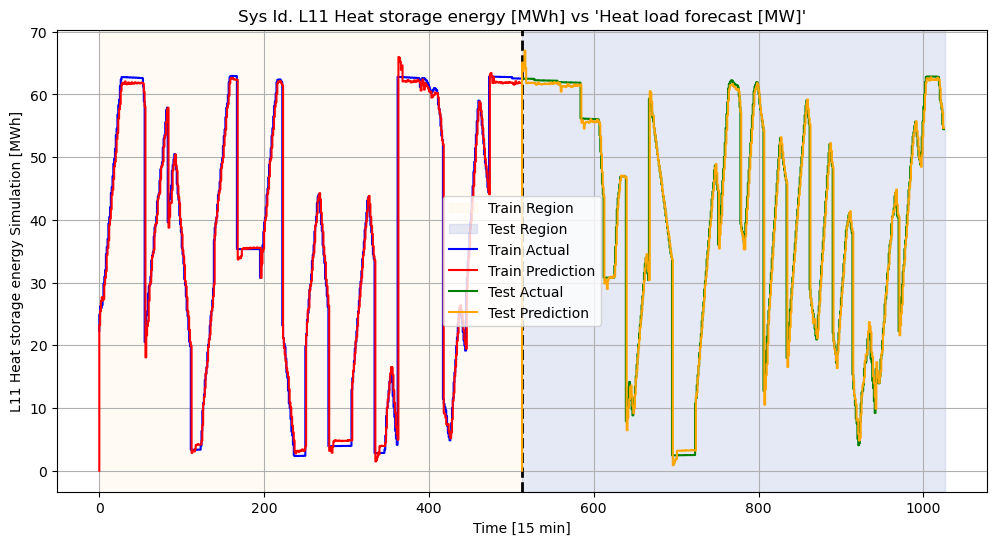

In [41]:
plt.figure(figsize=(12, 6))
plt.axvspan(0, len(X_train), color='#FFF2DB', alpha=0.3, label='Train Region')
plt.axvspan(len(X_train), len(X_train) + len(X_test), color='#A9B5DF', alpha=0.3, label='Test Region')
plt.axvline(x=len(X_train), color='black', linestyle='--', linewidth=2)
plt.step(time_seq_train, y_train, label="Train Actual", color='blue')
plt.step(time_seq_train, y_pred_train, label="Train Prediction", color='red', linestyle='-')
plt.step(range(len(X_train), len(X_train) + len(X_test)), y_test, label="Test Actual", color='green')
plt.step(range(len(X_train), len(X_train) + len(X_test)), y_pred_test, label="Test Prediction", color='orange', linestyle='-')
plt.xlabel("Time [15 min]")
plt.ylabel("L11 Heat storage energy Simulation [MWh]")
plt.title("Sys Id. L11 Heat storage energy [MWh] vs 'Heat load forecast [MW]'")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
train_len = len(X_train)
test_len = len(X_test)

fig = go.Figure()

# Add shaded regions for train and test
fig.add_shape(
    type="rect", x0=0, x1=train_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
    fillcolor="#FFF2DB", opacity=0.3, layer="below", line_width=0, name="Train Region"
)
fig.add_shape(
    type="rect", x0=train_len, x1=train_len + test_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
    fillcolor="#A9B5DF", opacity=0.3, layer="below", line_width=0, name="Test Region"
)

# Add vertical separator line
fig.add_shape(
    type="line", x0=train_len, x1=train_len, y0=min(y_train + y_test), y1=max(y_train + y_test),
    line=dict(color="black", width=2, dash="dash")
)

# Add step plots
fig.add_trace(go.Scatter(x=time_seq_train, y=y_train, mode='lines', line=dict(shape='hv', color='blue'), name="Train Actual"))
fig.add_trace(go.Scatter(x=time_seq_train, y=y_pred_train, mode='lines', line=dict(shape='hv', color='red'), name="Train Prediction"))
fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y=y_test, mode='lines', line=dict(shape='hv', color='green'), name="Test Actual"))
fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y=y_pred_test, mode='lines', line=dict(shape='hv', color='orange'), name="Test Prediction"))
fig.add_trace(go.Scatter(x=time_seq_train, y=X_train, mode='lines', line=dict(shape='hv', color='black'), name="Train MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=list(range(train_len, train_len + test_len)), y= X_test, mode='lines', line=dict(shape='hv', color='black'), name="Test MW", yaxis="y2"))

# Layout settings
fig.update_layout(
    title="Sys Id. L11 Heat storage energy [MWh] vs 'Heat load forecast [MW]'",
    xaxis_title="Time [15 min]",
    yaxis_title="L11 Heat storage energy Simulation [MWh]",
    yaxis2=dict(
        title="Heat Load [MW]",
        overlaying="y",
        side="right"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

# Show plot
fig.show()


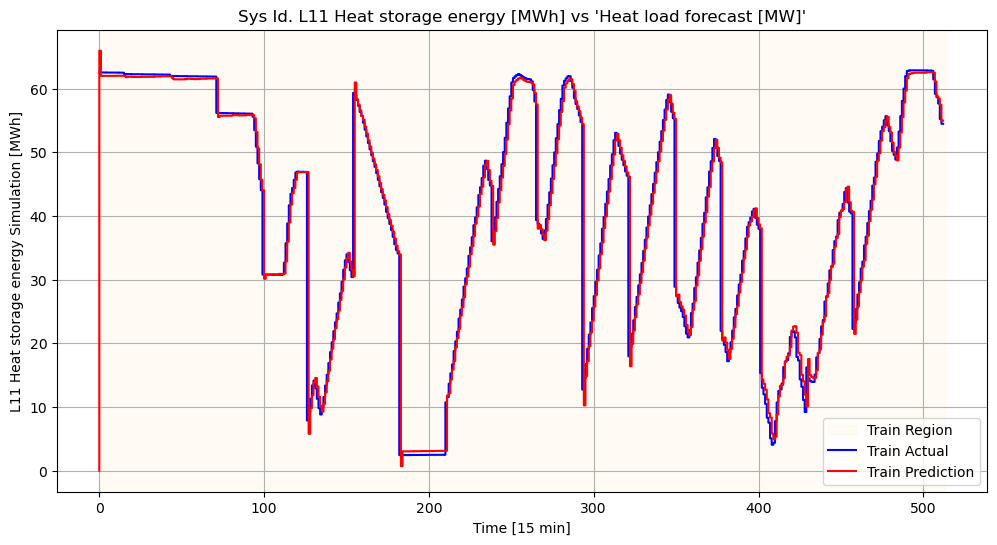

In [37]:
plt.figure(figsize=(12, 6))
plt.axvspan(0, len(X_test), color='#FFF2DB', alpha=0.3, label='Train Region')
plt.step(time_seq_test, y_test, label="Train Actual", color='blue')
plt.step(time_seq_test, y_pred_test, label="Train Prediction", color='red', linestyle='-')
plt.xlabel("Time [15 min]")
plt.ylabel("L11 Heat storage energy Simulation [MWh]")
plt.title("Sys Id. L11 Heat storage energy [MWh] vs 'Heat load forecast [MW]'")
plt.legend()
plt.grid(True)
plt.show()